In [1]:
import os

dataset_path = os.environ["DATA"] + "/00_datasets/DFT/OD9_7_smi_datasets"

cache_location = os.environ["CACHE_CHEM2020"]
json_cache_location = os.environ["DATA"] + "/00_datasets/DFT/cache_OD9_step7.json"
figures_output_path = os.environ["FIGURES"] + "/07_BBO/02_models/03.05_HOMO_prediction_errors_study"

In [2]:
from os import makedirs
makedirs(figures_output_path, exist_ok=True)

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern, RationalQuadratic, DotProduct
from sklearn.kernel_ridge import KernelRidge

gpr_kernels = [
           ("1.0 * RBF( 1.0)", 1.0 * RBF(1.0)),
           ("1 * Matern( length_scale=1, nu=2.5)", 1 * Matern(length_scale=1, nu=2.5)),
           ("1 * DotProduct( sigma_0=1)", 1 * DotProduct(sigma_0=1))]

gpr_alphas = [1e-1]

models = []
for kernel in gpr_kernels:
    for alpha in gpr_alphas:
        models.append((kernel[0] + " alpha=" + str(alpha), GaussianProcessRegressor(kernel=kernel[1], alpha=alpha)))


In [21]:
krr_linear_alpha = 1e-1 
krr_polynomial_alpha = 1e-4

models.extend(
    [("KRR(linear) alpha=" + str(krr_linear_alpha), KernelRidge(kernel="linear", alpha=krr_linear_alpha)),
     ("KRR(polynomial) alpha=" + str(krr_polynomial_alpha), KernelRidge(kernel="polynomial", alpha=krr_polynomial_alpha))]
)

In [22]:
from bbo.descriptor import SOAPDesc, ShinglesVectDesc, MBTRDesc, CoulombMatrixDesc
from bbo.geometry import dft_cache_xyz

descriptors = [
    ("SOAP_avg_MMFF94", SOAPDesc(cache_location=None, n_jobs=12, average="inner", rcut=4, nmax=4, 
                                 lmax=4, species=["C", "H", "O", "N", "F"])),
    ("MBTR", MBTRDesc(cache_location=None, n_jobs=12, cosine_angles_n=50, atomic_numbers_n=50, 
                      inverse_distances_n=50, species=["C", "H", "O", "N", "F"])),
    ("Shingles count", ShinglesVectDesc(cache_location=None, count=True))
]

# descriptors = [("SOAP", SOAPDesc(cache_location=None, n_jobs=12, rcut=4, nmax=6, lmax=6, species=["C", "H", "O", "N", "F"]))]


In [23]:
from bbo.objective_dft import DFTEnergyObjective

objective = DFTEnergyObjective("homo", cache_location, json_cache_location=json_cache_location)

In [24]:
from os.path import join
import numpy as np
from sklearn.preprocessing import normalize, scale


def compute_desc_obj(smiles_list, desc_builder, objective):
    
    X, success = desc_builder.transform(smiles_list)
    X = X[success]
        
    smiles_list = np.array(smiles_list)[success]
    
    y, success = objective.transform(smiles_list)
    
    return X[success], y[success]
    

def compute_data_descriptor(desc_builder, objective):
    
    smiles_train = []
    smiles_test = []
    
    with open(join(dataset_path, "train_test_dataset_1000.smi"), "r") as f:
        for smi in f.readlines():
            smiles_train.append(smi.rstrip())
            
    with open(join(dataset_path, "validation.smi"), "r") as f:
        for smi in f.readlines()[:2000]:
            smiles_test.append(smi.rstrip())
                        
    X_train, y_train = compute_desc_obj(smiles_train, desc_builder, objective)
    X_test, y_test = compute_desc_obj(smiles_test, desc_builder, objective)
    
        
    return X_train, X_test, y_train, y_test
    
    



In [25]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error
import time
from sklearn.preprocessing import StandardScaler

def evaluate_model(model, X_train, X_test, y_train, y_test, pipeline=None):
    
    tstart = time.time()
    
    model.fit(X_train, y_train)
    
    time_fit = time.time() - tstart
    
    tstart = time.time()
    
    y_pred = model.predict(X_test)
    
    time_predict = time.time() - tstart
        
    return y_pred, float(mean_absolute_error(y_test, y_pred)), time_fit, time_predict


In [26]:
def evaluate_models(pipeline=None):
    
    results_dict = {
        "mae": {"model":[str(model[0]) for model in models]},
        "y_test": {"model":[str(model[0]) for model in models]},
        "y_train": {"model":[str(model[0]) for model in models]},
        "y_pred": {"model":[str(model[0]) for model in models]},
        "time_fit":{"model":[str(model[0]) for model in models]},
        "time_predict": {"model":[str(model[0]) for model in models]},
    }
    
    for descriptor in descriptors:
        
        print("descriptor : " + descriptor[0])
        
        X_train, X_test, y_train, y_test = compute_data_descriptor(descriptor[1], objective)
        
        if pipeline is not None:

            X_train = pipeline.fit_transform(X_train)
            X_test = pipeline.transform(X_test)
        
        print("descriptors computed")

        for model in models:
            
            try:
                
                for k, v in results_dict.items():
                    if descriptor[0] not in v:
                        v[descriptor[0]] = []
                        
                y_pred, mae, time_fit, time_predict = evaluate_model(model[1], X_train, X_test, y_train, y_test, pipeline)

                results_dict["mae"][descriptor[0]].append(mae)
                results_dict["y_test"][descriptor[0]].append(y_test)
                results_dict["y_train"][descriptor[0]].append(y_train)
                results_dict["y_pred"][descriptor[0]].append(y_pred)
                results_dict["time_fit"][descriptor[0]].append(time_fit)
                results_dict["time_predict"][descriptor[0]].append(time_predict)
                
            except Exception as e:
                
                raise e
                results_dict["mae"][descriptor[0]].append(np.nan)
                results_dict["y_test"][descriptor[0]].append([])
                results_dict["y_train"][descriptor[0]].append([])
                results_dict["y_pred"][descriptor[0]].append([])
                results_dict["time_fit"][descriptor[0]].append(np.nan)
                results_dict["time_predict"][descriptor[0]].append(np.nan)
    
    return results_dict

In [27]:
results_dict = evaluate_models()

descriptor : SOAP_avg_MMFF94
descriptors computed
descriptor : MBTR
descriptors computed
descriptor : Shingles count
descriptors computed


In [28]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt

def plot_results(results_dict):
    
    plt.figure(figsize=(25, 35))
    
    keys = []
    models_idx = {}
    
    for i, model_key in enumerate(results_dict["mae"]["model"]):
        models_idx[model_key] = i
        for descriptor_key in results_dict["mae"].keys():
            if descriptor_key != "model":
                keys.append((model_key, descriptor_key))
    
    for i, k in enumerate(keys):
        
        curr_model = k[0]
        curr_desc = k[1]
        
        plt.subplot(5, 3, i+1)
        
        y_test = results_dict["y_test"][curr_desc][models_idx[curr_model]]
        y_pred = results_dict["y_pred"][curr_desc][models_idx[curr_model]]
        mae = results_dict["mae"][curr_desc][models_idx[curr_model]]
        
        
        xmin, xmax = -10, -2
        if mae < 1:             
            ymin, ymax = -10, -2
        else:
            ymin, ymax = -10, 1
        
        plt.ylim(ymin, ymax)
        plt.xlim(xmin, xmax)

            
        plt.title(curr_model + " " + curr_desc + " MAE : " + "{:.2f}".format(mae))
        
        plt.scatter(y_test, y_pred, marker=',', lw=0, s=1)
        
        x_line = np.linspace(xmin, xmax, 10)
        y_line = np.linspace(ymin, ymax, 10)
        plt.plot(x_line, x_line)
        
        
        
    plt.show()

ValueError: num must be 1 <= num <= 15, not 16

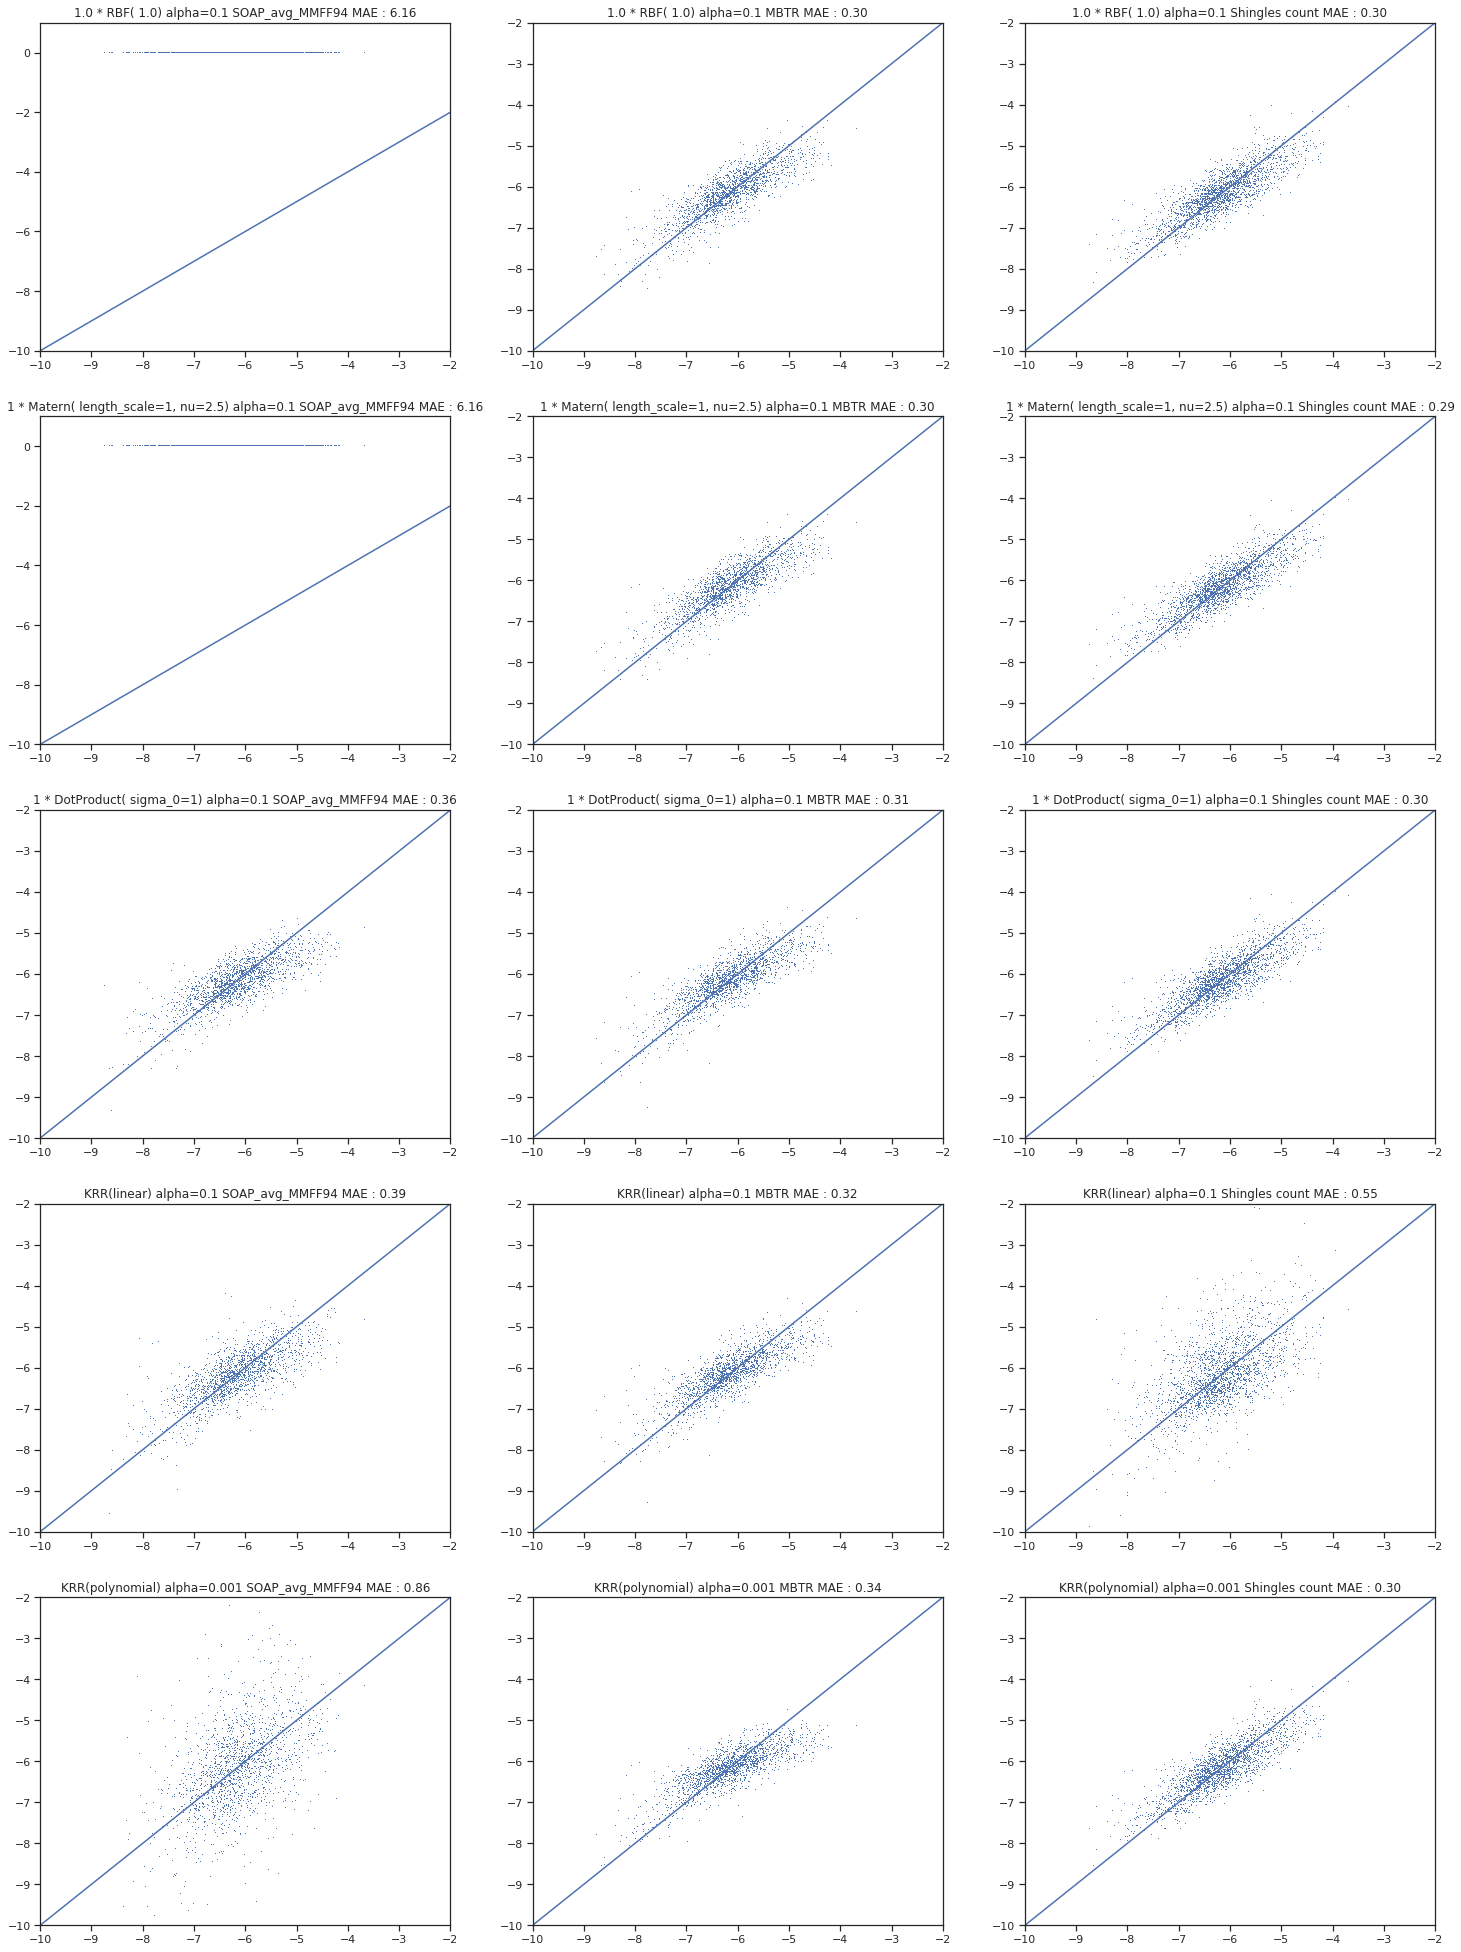

In [29]:
plot_results(results_dict)

In [ ]:
def plot_y_train_distrib(results_dict):
    
    plt.figure(figsize=(8, 5))
    
    y_test = results_dict["y_test"][list(results_dict["y_test"].keys())[1]][0]
    print(y_test)
    sns.distplot(y_test)
    plt.show()

In [ ]:
plot_y_train_distrib(results_dict)